<a href="https://colab.research.google.com/github/IronVr/Machine_learning_technologies/blob/Disbalanced-dataset/Disbalanced_dataset_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
new_df=pd.read_csv("creditcard.csv", delimiter=',', encoding='UTF-8')
df = pd.read_csv("creditcard_full.csv", delimiter=',', encoding='UTF-8')
new_df = new_df.drop(new_df.columns[0], axis=1)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h1 align="center"> ФМИ. Disbalanced dataset.  Part 2 </h1>
<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данном семинаре мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные.</li>
<li> Решить проблему сильного дисбаланса классов.  </li>
<li>Построить модели на основе классических алгоритмов машинного обучения. </li>
<li> Провести сравнительный анализ классических подходов.</li>

In [3]:
'''
Работаем с маленьким датасетом new_df
Делаем из него 2 набора.
В первом - все столбцы, но нет целевой переменной.
Во втором - столбец с целевой переменной.
'''

print(new_df.shape)

X = new_df.drop('Class', axis=1)
y = new_df['Class']

(284807, 30)


In [4]:
# Про масштабирование мы с вами уже в курсе. Опять используем RobustScaler

from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,
                                                    stratify = y)

X_train['scaled_amount'] = rob_scaler.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_test['scaled_amount'] = rob_scaler.fit_transform(X_test['Amount'].values.reshape(-1,1))

X_train['scaled_time'] = rob_scaler.fit_transform(X_train['Time'].values.reshape(-1,1))
X_test['scaled_time'] = rob_scaler.fit_transform(X_test['Time'].values.reshape(-1,1))


# удаляем из трейн и тест датасетов  столбцы Time и Amount,
# так как у нас уже есть их отмасштабированные версии
X_train.drop(['Time','Amount'], axis=1, inplace=True)
X_test.drop(['Time','Amount'], axis=1, inplace=True)

KeyError: 'Time'

In [ ]:
X_train['scaled_amount']

,scaled_amount
531,-0.194598
475,-0.027985
628,-0.194598
68,1.454663
253,-0.121392
...,...
72,0.009267
298,-0.194598
43,0.898856
375,-0.176064


In [ ]:
X_train['scaled_time']

,scaled_time
531,-0.463002
475,-0.243836
628,0.479866
68,-0.645909
253,-0.069226
...,...
72,0.651240
298,-0.195897
43,-0.091409
375,-0.377282


In [ ]:
# Переводим данные в массив для подачи в классификатор
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Выберем несколько простых моделей из библиотеки sklearn

classifiers = {
    "LogisiticRegression": LogisticRegression(),  # Логистическая регрессия
    "KNearest": SVC(),  # Метод опорных векторов
    "Support Vector Classifier": KNeighborsClassifier(),# Метод ближайших соседей
    "DecisionTreeClassifier": DecisionTreeClassifier() # Решающее дерево
}

Для борьбы с переобучением будем использовать кросс-валидацию.

<img src="https://scikit-learn.ru/wp-content/uploads/2021/10/image-161.png" width=800>

Разобьем обучающую выборку на 5 фолдов и обучим наши модели.

Кросс-валидация — это метод оценки качества модели, который позволяет проверить ее способность обобщать, избегая переобучения. Этот метод заключается в следующем:
- Разделение данных: Исходный набор данных делится на несколько частей (или "фолдов"). Обычно используется от 5 до 10 фолдов.
- Обучение и тестирование: Модель обучается на части данных (например, на 4 фолдах), а затем тестируется на оставшейся части (1 фолде). Этот процесс повторяется для каждого из фолдов.
- Средний результат: После завершения всех итераций рассчитывается средний показатель качества (например, точность), чтобы получить более надежную оценку производительности модели.
Преимущества кросс-валидации:
- Позволяет избежать переобучения, так как модель проверяется на разных подмножестве данных.
- Обеспечивает более надежную оценку производительности модели по сравнению с простым разделением на тренировочный и тестовый наборы.
Кросс-валидация помогает лучше понять, как модель будет вести себя на новых, ранее невидимых данных, что критически важно для задач машинного обучения.

In [ ]:
from sklearn.model_selection import cross_val_score  # Импортируем функцию для кросс-валидации

# Проходим по всем классификаторам в словаре classifiers
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)  # Обучаем классификатор на тренировочных данных

    # Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)

    # Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
    print("Модель ", classifier.__class__.__name__, "получила на обучающей выборке",
          round(training_score.mean(), 2) * 100, "% accuracy score")


Модель  LogisticRegression получила на обучающей выборке 93.0 % accuracy score
Модель  SVC получила на обучающей выборке 95.0 % accuracy score
Модель  KNeighborsClassifier получила на обучающей выборке 94.0 % accuracy score
Модель  DecisionTreeClassifier получила на обучающей выборке 90.0 % accuracy score


Для улучшения качества моделей переберем по сетке различные гиперпараметры методом GridSearchCV.


In [ ]:
# Используем поиск по сетке для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Логистическая регрессия
# Определяем набор гиперпараметров для логистической регрессии
# 'penalty' определяет норму регуляризации (l1 или l2)
# 'C' — величина регуляризации (чем больше значение, тем меньше регуляризация)
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Создаем объект GridSearchCV для логистической регрессии
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)

# Обучаем модель на тренировочных данных
grid_log_reg.fit(X_train, y_train)

# Выбираем лучшую модель из найденных гиперпараметров
log_reg = grid_log_reg.best_estimator_  # для Логистическая регрессия

# Метод ближайших соседей
# Определяем набор гиперпараметров для метода K ближайших соседей
# 'n_neighbors' — количество соседей, которые будут учитываться
# 'algorithm' — способ, используемый для вычисления ближайших соседей
knears_params = {"n_neighbors": list(range(2, 7, 1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Создаем объект GridSearchCV для K ближайших соседей
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)

# Обучаем модель на тренировочных данных
grid_knears.fit(X_train, y_train)

# Выбираем лучшую модель из найденных гиперпараметров
knears_neighbors = grid_knears.best_estimator_  # для K ближайший соседей


# Метод опорных векторов (SVM)
# Определяем набор гиперпараметров для SVM
# 'C' — величина регуляризации
# 'kernel' — тип ядра (rbf или poly)
# 'gamma' — параметр ядра
# 'degree' — степень полиномиального ядра
x = [1.0, 1000.0]
y = [0.9]
z = [4]
svc_params = [
    {'C': x, 'kernel': ['rbf'], 'gamma': y},
    {'C': x, 'kernel': ['poly'], 'gamma': y, 'degree': z}
]

# Создаем объект GridSearchCV для SVM
grid_svc = GridSearchCV(estimator=SVC(),
                        param_grid=svc_params,
                        scoring='accuracy',  # Критерий оценки модели
                        cv=3,  # Количество фолдов для кросс-валидации
                        n_jobs=-1)  # Используем все доступные ядра CPU

# Обучаем модель на тренировочных данных
grid_svc.fit(X_train, y_train)

# Выбираем лучшую модель из найденных гиперпараметров
svc = grid_svc.best_estimator_  # для SVM


# Решающее дерево
# Определяем набор гиперпараметров для решающего дерева
# 'criterion' — способ оценки качества разделения (gini или entropy)
# 'max_depth' — максимальная глубина дерева
# 'min_samples_leaf' — минимальное количество образцов, необходимых для листа
tree_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(2, 7, 1)),
    "min_samples_leaf": list(range(5, 7, 1))
}

# Создаем объект GridSearchCV для решающего дерева
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)

# Обучаем модель на тренировочных данных
grid_tree.fit(X_train, y_train)

# Выбираем лучшую модель из найденных гиперпараметров
tree_clf = grid_tree.best_estimator_  # для решающих деревьев


In [ ]:
# Проверим, как поменялись метрики
from sklearn.model_selection import cross_val_score

# Оцениваем модель логистической регрессии с помощью кросс-валидации
# cross_val_score возвращает массив оценок для каждой из 5 фолдов
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)

# Выводим средний балл модели с округлением до двух знаков после запятой и преобразуем в проценты
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


# Оцениваем модель K ближайших соседей аналогично
knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)

# Выводим средний балл модели K ближайших соседей
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')


# Оцениваем модель поддержки векторов (SVC) с помощью кросс-валидации
svc_score = cross_val_score(svc, X_train, y_train, cv=5)

# Выводим средний балл модели SVC
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')


# Оцениваем модель решающего дерева
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)

# Выводим средний балл модели решающего дерева
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  94.44%
Knears Neighbors Cross Validation Score 94.64%
Support Vector Classifier Cross Validation Score 91.46%
DecisionTree Classifier Cross Validation Score 93.06%


Видим явное улучшение!

Давайте теперь попробуем более умные способы undersampling. Например, с помощью NearMiss, который оценивает среднее расстояние между классами. Поможет нам в этом специальная библиотека для работы с несбалансированными даннными imblearn.

In [ ]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline  # импортируем функцию для создания пайплайнов с учетом дисбаланса классов
from imblearn.over_sampling import SMOTE  # импортируем SMOTE для перегруппировки данных
from imblearn.under_sampling import NearMiss  # импортируем метод NearMiss для уменьшения числа примеров в большом классе
from imblearn.metrics import classification_report_imbalanced  # импортируем отчет о классификации для несбалансированных классов
from sklearn.model_selection import StratifiedKFold  # импортируем метод для стратифицированной кросс-валидации
from sklearn.preprocessing import RobustScaler  # импортируем RobustScaler для масштабирования данных

# Создаем объект RobustScaler для масштабирования признаков, который менее чувствителен к выбросам
rob_scaler = RobustScaler()

# Создаем объект StratifiedKFold для разделения данных на 5 фолдов с сохранением пропорций классов
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

'''
StratifiedKFold — это метод кросс-валидации, который разделяет данные на несколько фолдов (разделов), сохраняя пропорции классов в каждой из этих частей.
Это особенно полезно при работе с несбалансированными датасетами, где одни классы могут быть представлены гораздо больше, чем другие.
Основные функции StratifiedKFold:
- Сохранение пропорций: При разделении данных на обучающие и тестовые фолды, StratifiedKFold следит за тем, чтобы каждый фолд имел равное представительство классов, что позволяет
избежать ситуаций, когда в одном фолде будет недостаточно данных для обучения одного из классов.

- Стратифицированная кросс-валидация: Каждый фолд используется как тестовая выборка, в то время как остальные фолды используются для обучения модели. Этот процесс повторяется для
каждого фолда, что обеспечивает надежную оценку модели.

- Удобство использования: StratifiedKFold является частью библиотеки scikit-learn и очень просто интегрируется в процесс обучения моделей.

Использование StratifiedKFold помогает в улучшении оценки производительности модели, обеспечивая, что каждая обучающая и тестовая выборка является репрезентативной для всех
классов в датасете.
'''

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve, accuracy_score)  # Импортируем метрики для оценки модели

# Разделение данных на признаки (X) и целевую переменную (y)
undersample_X = df.drop('Class', axis=1)  # Убираем колонку 'Class' из X
undersample_y = df['Class']  # Целевая переменная y

# Делим данные на тренировочную и тестовую выборки с учетом стратификации по целевому классу
undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = train_test_split(
    undersample_X, undersample_y,
    test_size=0.2,
    random_state=42,
    stratify=undersample_y)  # Упорядочиваем выборку по классам

# Масштабируем колонку 'Amount' в обучающей и тестовой выборках
undersample_Xtrain['scaled_amount'] = rob_scaler.fit_transform(undersample_Xtrain['Amount'].values.reshape(-1, 1))
undersample_Xtest['scaled_amount'] = rob_scaler.fit_transform(undersample_Xtest['Amount'].values.reshape(-1, 1))

# Масштабируем колонку 'Time' в обучающей и тестовой выборках
undersample_Xtrain['scaled_time'] = rob_scaler.fit_transform(undersample_Xtrain['Time'].values.reshape(-1, 1))
undersample_Xtest['scaled_time'] = rob_scaler.fit_transform(undersample_Xtest['Time'].values.reshape(-1, 1))

# Убираем оригинальные колонки 'Time' и 'Amount' из данных
undersample_Xtrain.drop(['Time', 'Amount'], axis=1, inplace=True)
undersample_Xtest.drop(['Time', 'Amount'], axis=1, inplace=True)

# Преобразуем данные в массивы numpy для использования в модели
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

# Инициализируем списки для сохранения метрик после каждой итерации
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Применяем метод NearMiss для уменьшения количества примеров в большом классе
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss распределение классов: {}'.format(Counter(y_nearmiss)))  # Выводим новое распределение классов после применения NearMiss

# Используем кросс-валидацию для оценки модели
for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)  # Создаем пайплайн с учетом метода NearMiss и модели логистической регрессии
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])  # Обучаем модель на тренировочных данных из текущего фолда
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])  # Делаем предсказания на тестовых данных из текущего фолда

    # Сохраняем метрики для каждого фолда
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))  # Точность
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))  # Точность (precision)
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))  # Полнота (recall)
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))  # F1-меры
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))  # ROC AUC



NearMiss распределение классов: Counter({0: 492, 1: 492})


In [ ]:
print(undersample_accuracy)

[0.819350874498014, 0.7087054796023613, 0.8332418969035967, 0.6995106322280498, 0.8567886062893634]


In [ ]:
print(undersample_precision)

[0.008795180722891566, 0.005471853684131624, 0.008753592892605173, 0.0053771254178171775, 0.010923987255348202]


In [ ]:
print(undersample_recall)

[0.9358974358974359, 0.9240506329113924, 0.8481012658227848, 0.9367088607594937, 0.9113924050632911]


In [ ]:
print(undersample_f1)

[0.01742659345905944, 0.010879284649776453, 0.0173283331178068, 0.010692869012354599, 0.02158920539730135]


In [ ]:
print(undersample_auc)

[0.877524238381331, 0.8161910671701389, 0.8406586786357274, 0.8179037818855722, 0.8840430919578931]


Построим кривую обучение каждой из модели. Данная кривая показывает различие между метриками во время обычного обучения и во время кросс-валидации.

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import seaborn as sn

In [ ]:
def plot_learning_curves(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    # Создание подграфиков для отображения кривых обучения
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14), sharey=True)

    # Установка пределов по оси Y, если задано
    if ylim is not None:
        plt.ylim(*ylim)

    # Первая модель
    # Получение кривых обучения для первой модели
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    # Вычисление среднего и стандартного отклонения для обучающих данных
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Вычисление среднего и стандартного отклонения для тестовых данных
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Заполнение области между средним и стандартным отклонением (обучающая выборка)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    # Заполнение области между средним и стандартным отклонением (тестовая выборка)
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")

    # Построение кривых для обучающей и тестовой выборки
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")  # Обучающий score
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")  # Тестовый score

    # Настройка заголовка и меток осей
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Размер выборки')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Процесс аналогичен для второй модели
    # Вторая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")

    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")

    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Размер выборки')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Третья модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")

    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Размер выборки")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")

    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Четвертая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Размер выборки")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

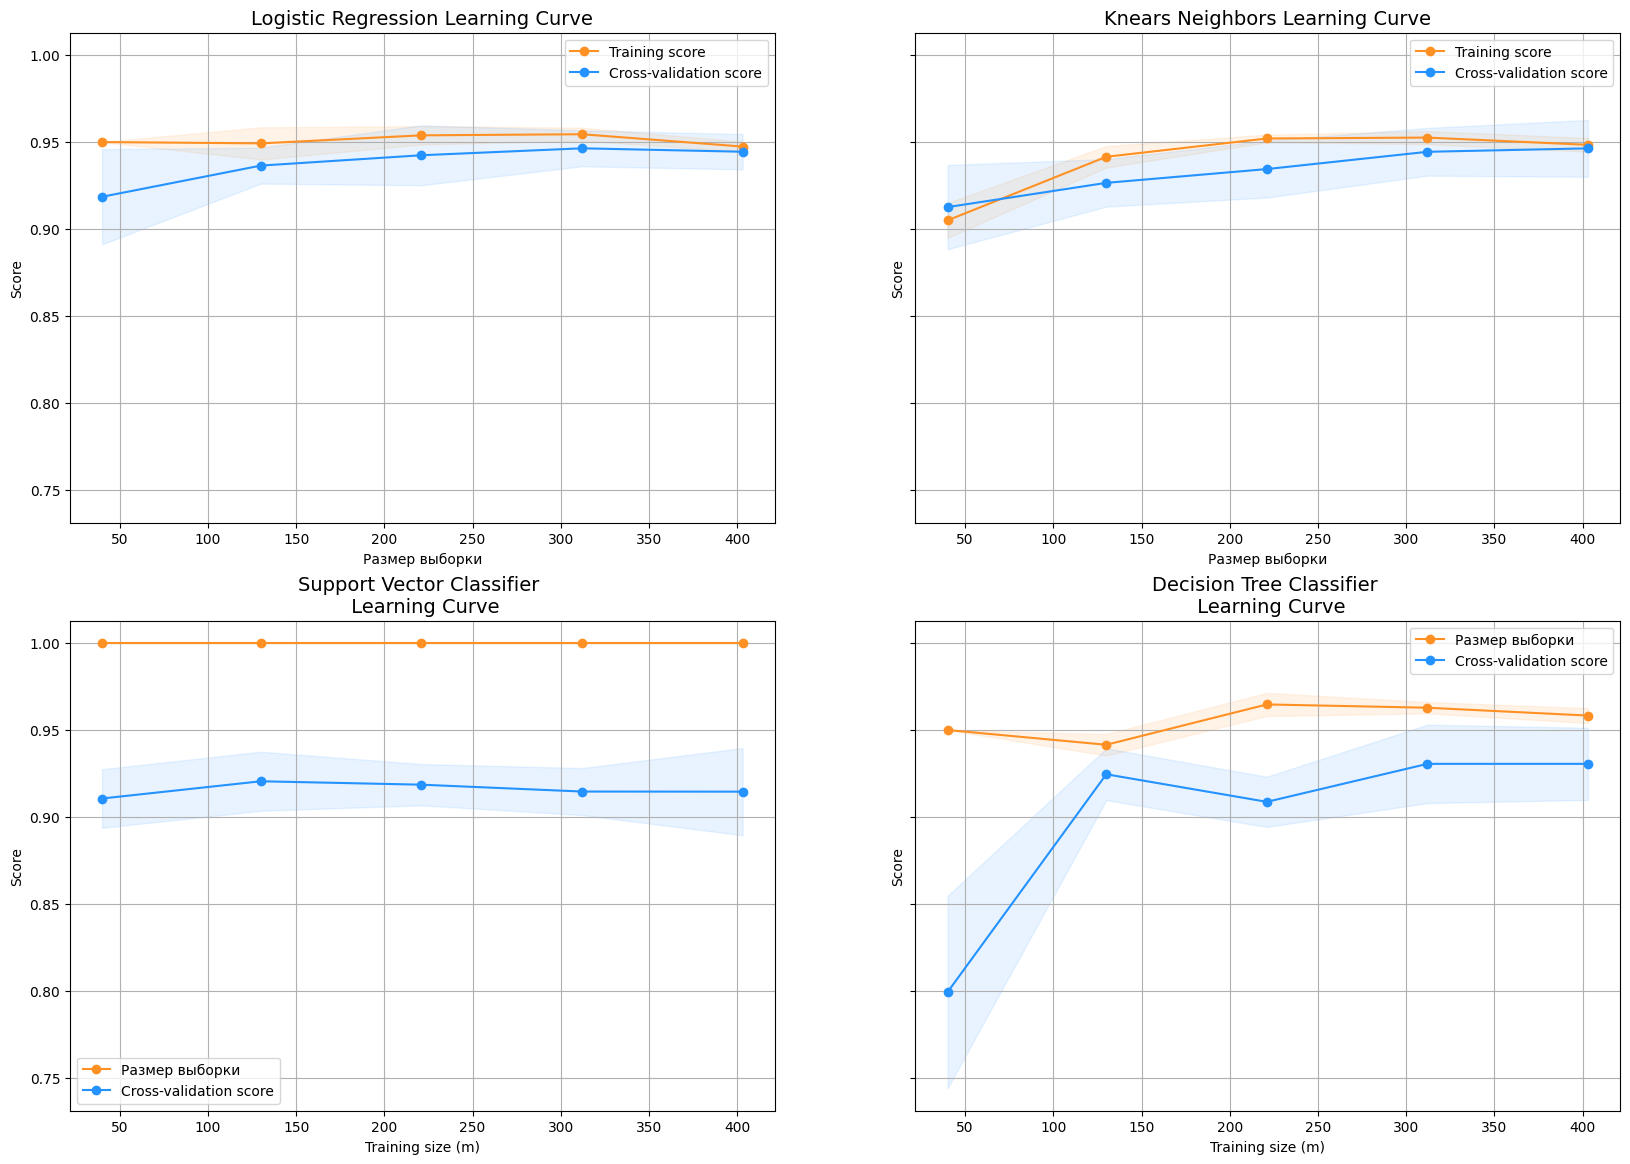

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curves(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train)

## Кривые обучения:
<ul>
<li>Чем больше разрыв между результатами обучения и результатами кросс-валидации, тем больше вероятность того, что модель переобучилась (большой разброс).</li>
<li> Если результаты низкие как на обучающем, так и на кросс-валидационном наборе, это указывает на то, что наша модель недообучилась (большое смещение).</li>
<li>Логистическая регрессия показала себя лучше остальных.</li>
</ul>

Друой метод кросс валидации cross_val_predict

In [ ]:
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9695670592222316
KNears Neighbors:  0.9281623316106075
Support Vector Classifier:  0.937371854613234
Decision Tree Classifier:  0.91675845124121


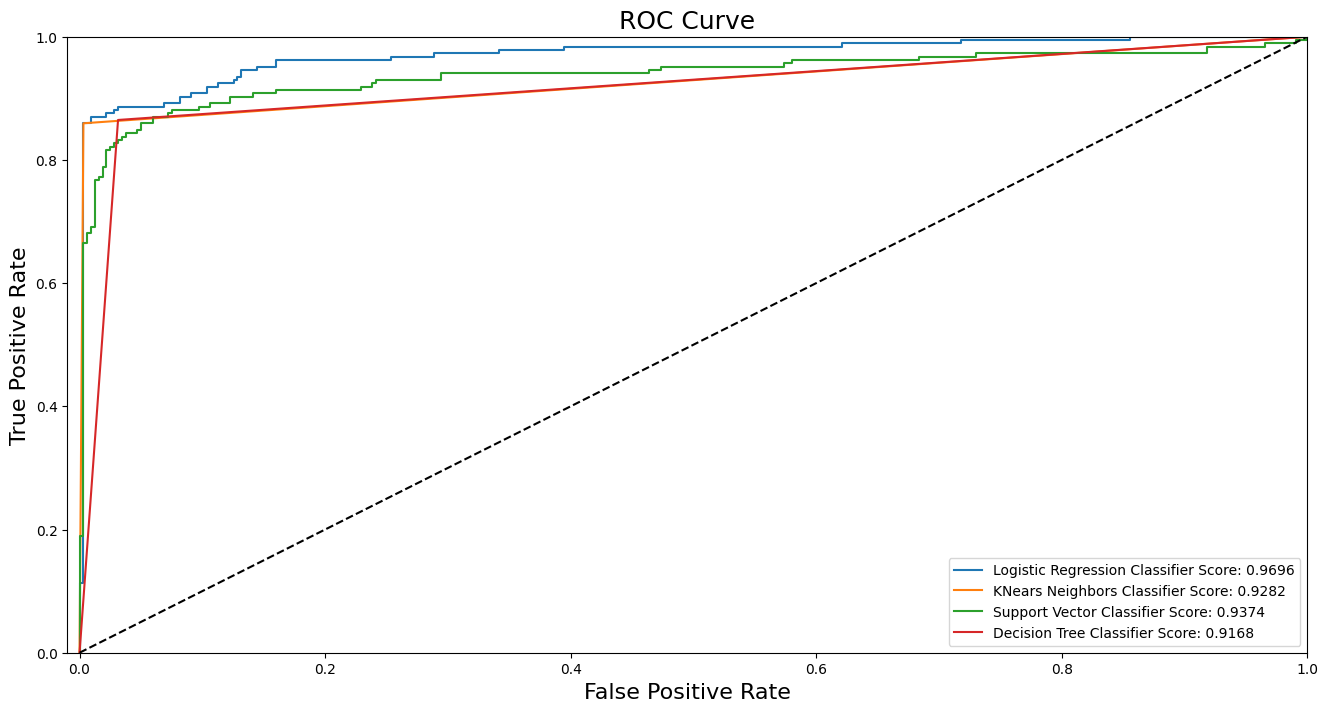

In [ ]:
# Вычисление ROC-кривых для различных классификаторов на обучающем наборе данных.
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)  # ROC-кривая для логистической регрессии
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)  # ROC-кривая для ближайших соседей
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)  # ROC-кривая для SVC
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)  # ROC-кривая для дерева решений

# Функция для графического отображения ROC-кривых нескольких классификаторов
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16, 8))  # Задаем размер графика
    plt.title('ROC Curve', fontsize=18)  # Заголовок графика

    # Строим линии ROC-кривых для каждого классификатора с отображением AUC (Area Under Curve)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))

    # Добавляем диагональную линию для случайного классификатора
    plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного выбора

    # Ограничения по осям графика
    plt.axis([-0.01, 1, 0, 1])  # Устанавливаем пределы для осей X и Y
    plt.xlabel('False Positive Rate', fontsize=16)  # Подпись для оси X
    plt.ylabel('True Positive Rate', fontsize=16)  # Подпись для оси Y
    plt.legend()  # Отображение легенды

# Вызов функции для построения ROC-кривых
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)

plt.show()  # Отображение графика



### SMOTE метод (Over-Sampling):

<b>SMOTE</b> означает Synthetic Minority Over-sampling Technique.  В отличие от Random Under-Sampling, SMOTE создает новые синтетические точки для того, чтобы создать баланс классов. Это еще одна альтернатива для решения проблемы дисбаланса классов. <br><br>


<b> Принцип работы SMOTE: </b>
<ul>
<li><b>Генерация синтетических точек: </b> SMOTE выбирает расстояние между ближайшими соседями меньшего класса и между ними создает синтетические точки. </li>
<li> <b>Преимущество:  </b> Сохраняется больше информации, поскольку нам не пришлось удалять данные, в отличие от under-sampling.</li>
</ul>

### Правильное использование SMOTE
Если мы создадим синтетические точки перед кросс-валидацией, мы окажем определенное влияние на тестовое выборку. Но тестовая выборка не должна быть тронута! По этой причине мы должны создавать синтетические точки данных во время кросс-валидации, а не до нее.

Попробуем в качестве алгоритм подбора гиперпараметров случайный поиск. Он работает быстрее, чем поиск по сетке.

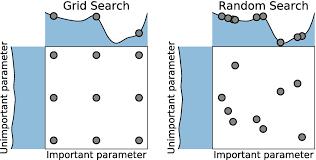

In [ ]:
# Берем кусок кода из предыдущего блокнота

from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


In [ ]:
tuned_classifiers = {
    "LogisiticRegression": log_reg,
    "Knears Neighbors": knears_neighbors,
    "Support Vector Classifier": svc,
    "DecisionTreeClassifier": tree_clf
}

# Проходим по всем классификаторам в словаре classifiers
for key, classifier in tuned_classifiers.items():
    classifier.fit(X_train, y_train)  # Обучаем классификатор на тренировочных данных

    # Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)

    # Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
    print("Модель ", classifier.__class__.__name__, "получила на обучающей выборке",
          round(training_score.mean(), 2) * 100, "% accuracy score")


Модель  LogisticRegression получила на обучающей выборке 94.0 % accuracy score
Модель  KNeighborsClassifier получила на обучающей выборке 95.0 % accuracy score
Модель  SVC получила на обучающей выборке 91.0 % accuracy score
Модель  DecisionTreeClassifier получила на обучающей выборке 93.0 % accuracy score


In [ ]:
# Импортируем библиотеки для балансировки классов
from imblearn.over_sampling import SMOTE  # Библиотека для техники увеличения выборки
from imblearn.under_sampling import RandomUnderSampler  # Библиотека для техники уменьшения выборки

# Импортируем библиотеки для создания пайплайнов машинного обучения
from imblearn.pipeline import Pipeline  # Пайплайн для комбинирования шагов обработки и классификации

# Определяем признаки и целевую переменную из несбалансированного набора данных
X = df.drop('Class', axis=1)  # Признаки (все столбцы кроме 'Class')
y = df['Class']  # Целевая переменная (столбец 'Class')

# Импортируем классы для стратифицированного кросс-валидации
from sklearn.model_selection import StratifiedKFold  # Класс для стратифицированной кросс-валидации

# Используем StratifiedKFold для обеспечения стратифицированной кросс-валидации
# Это объект кросс-валидации, который позволяет сохранить процент образцов для каждого класса в каждом фоне.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)  # 5 образцов для кросс-валидации

# Создаем объект для увеличения выборки для меньшинства
over = SMOTE(sampling_strategy=0.01, k_neighbors=5)  # Используем SMOTE для увеличения выборки с 1% от меньшинства

# Создаем объект для уменьшения выборки для большинства
under = RandomUnderSampler(sampling_strategy=0.5)  # Уменьшаем выборку большинства до 50% от меньшинства
# Итерируемся по словарю с настроенными классификаторами
for key, classifier in tuned_classifiers.items():
    # Создаем список шагов для пайплайна машинного обучения
    steps = [('o', over), ('u', under), ('model', classifier)]  # Шаги: увеличенная выборка, уменьшенная выборка и модель

    # Создаем пайплайн машинного обучения
    FiPipeline = Pipeline(steps=steps)  # Инициализация пайплайна с указанными шагами

    # Кросс-валидация классификаторов с использованием определенного пайплайна
    scores = cross_val_score(FiPipeline, original_Xtrain, original_ytrain, cv=sss)  # Оценка модели с помощью кросс-валидации

    # Выводим средний коэффициент точности
    print(f"Classifiers: {key} Has a training score of, {round(scores.mean() * 100, 2)} % accuracy score")  # Печать результатов


'\n# Итерируемся по словарю с настроенными классификаторами\nfor key, classifier in tuned_classifiers.items():\n    # Создаем список шагов для пайплайна машинного обучения\n    steps = [(\'o\', over), (\'u\', under), (\'model\', classifier)]  # Шаги: увеличенная выборка, уменьшенная выборка и модель\n\n    # Создаем пайплайн машинного обучения\n    FiPipeline = Pipeline(steps=steps)  # Инициализация пайплайна с указанными шагами\n\n    # Кросс-валидация классификаторов с использованием определенного пайплайна\n    scores = cross_val_score(FiPipeline, original_Xtrain, original_ytrain, cv=sss)  # Оценка модели с помощью кросс-валидации\n\n    # Выводим средний коэффициент точности\n    print(f"Classifiers: {key} Has a training score of, {round(scores.mean() * 100, 2)} % accuracy score")  # Печать результатов\n'

In [ ]:
# Проходим по фолдам данных для выполнения GridSearchCV для подбора лучших параметров для SMOTE
for train_index, test_index in sss.split(X, y):
    # Определяем индексы для обучения и тестирования из кросс-валидации
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]  # Разделяем признаки на обучающую и тестовую выборки
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]  # Разделяем целевую переменную на обучающую и тестовую выборки

# Создаем пайплайн машинного обучения
model = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.01)),  # Шаг для увеличения выборки меньшинства
    ('Random', RandomUnderSampler(sampling_strategy=0.5)),  # Шаг для уменьшения выборки большинства
    ('classification', log_reg)  # Шаг классификации (логистическая регрессия)
])

# Запускаем GridSearchCV на нашем пайплайне, варьируя k_neighbors от 1 до 10
# для нахождения лучшего значения параметра k_neighbors
# ЗАМЕТКА: в paramgrid используем ключ выше + 2 _ и потом название параметра
SMOTE_KN = GridSearchCV(model, {'sampling__k_neighbors': list(range(1, 10))})  # Инициализация GridSearchCV с параметрами для SMOTE
SMOTE_KN.fit(original_Xtrain, original_ytrain)  # Обучаем модель

# Выводим лучший оценщик, полученный в результате GridSearchCV
print(SMOTE_KN.best_estimator_)  # Печатаем лучшую модель с оптимальными параметрами
print(SMOTE_KN.best_score_)  # Печатаем лучший тестовый балл
print(SMOTE_KN.best_params_)  # Печатаем лучшие параметры

# Обучаем классификатор логистической регрессии, используя значение параметра k_neighbors, найденное с помощью SMOTE
log_reg_score = cross_val_score(SMOTE_KN.best_estimator_, original_Xtrain, original_ytrain, cv=5)  # Кросс-валидация с лучшим оценщиком

# Выводим средний коэффициент точности
print(f'Logistic Regression Cross Validation Score: {round(log_reg_score.mean() * 100, 2)}%')  # Печатаем результат



Pipeline(steps=[('sampling', SMOTE(k_neighbors=2, sampling_strategy=0.01)),
                ('Random', RandomUnderSampler(sampling_strategy=0.5)),
                ('classification', LogisticRegression(C=0.1))])
0.9793020623970093
{'sampling__k_neighbors': 2}
Logistic Regression Cross Validation Score: 96.92%


In [ ]:
labels = ['Non Fraud', 'Fraud']

best_est = SMOTE_KN.best_estimator_
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56863
       Fraud       0.64      0.80      0.71        98

    accuracy                           1.00     56961
   macro avg       0.82      0.90      0.86     56961
weighted avg       1.00      1.00      1.00     56961



In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Применим SMOTE после кросс-валидации
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Обучим логистическую регрессию
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Время обучения: {} сек".format(t1 - t0))

Время обучения: 10.588823556900024 сек


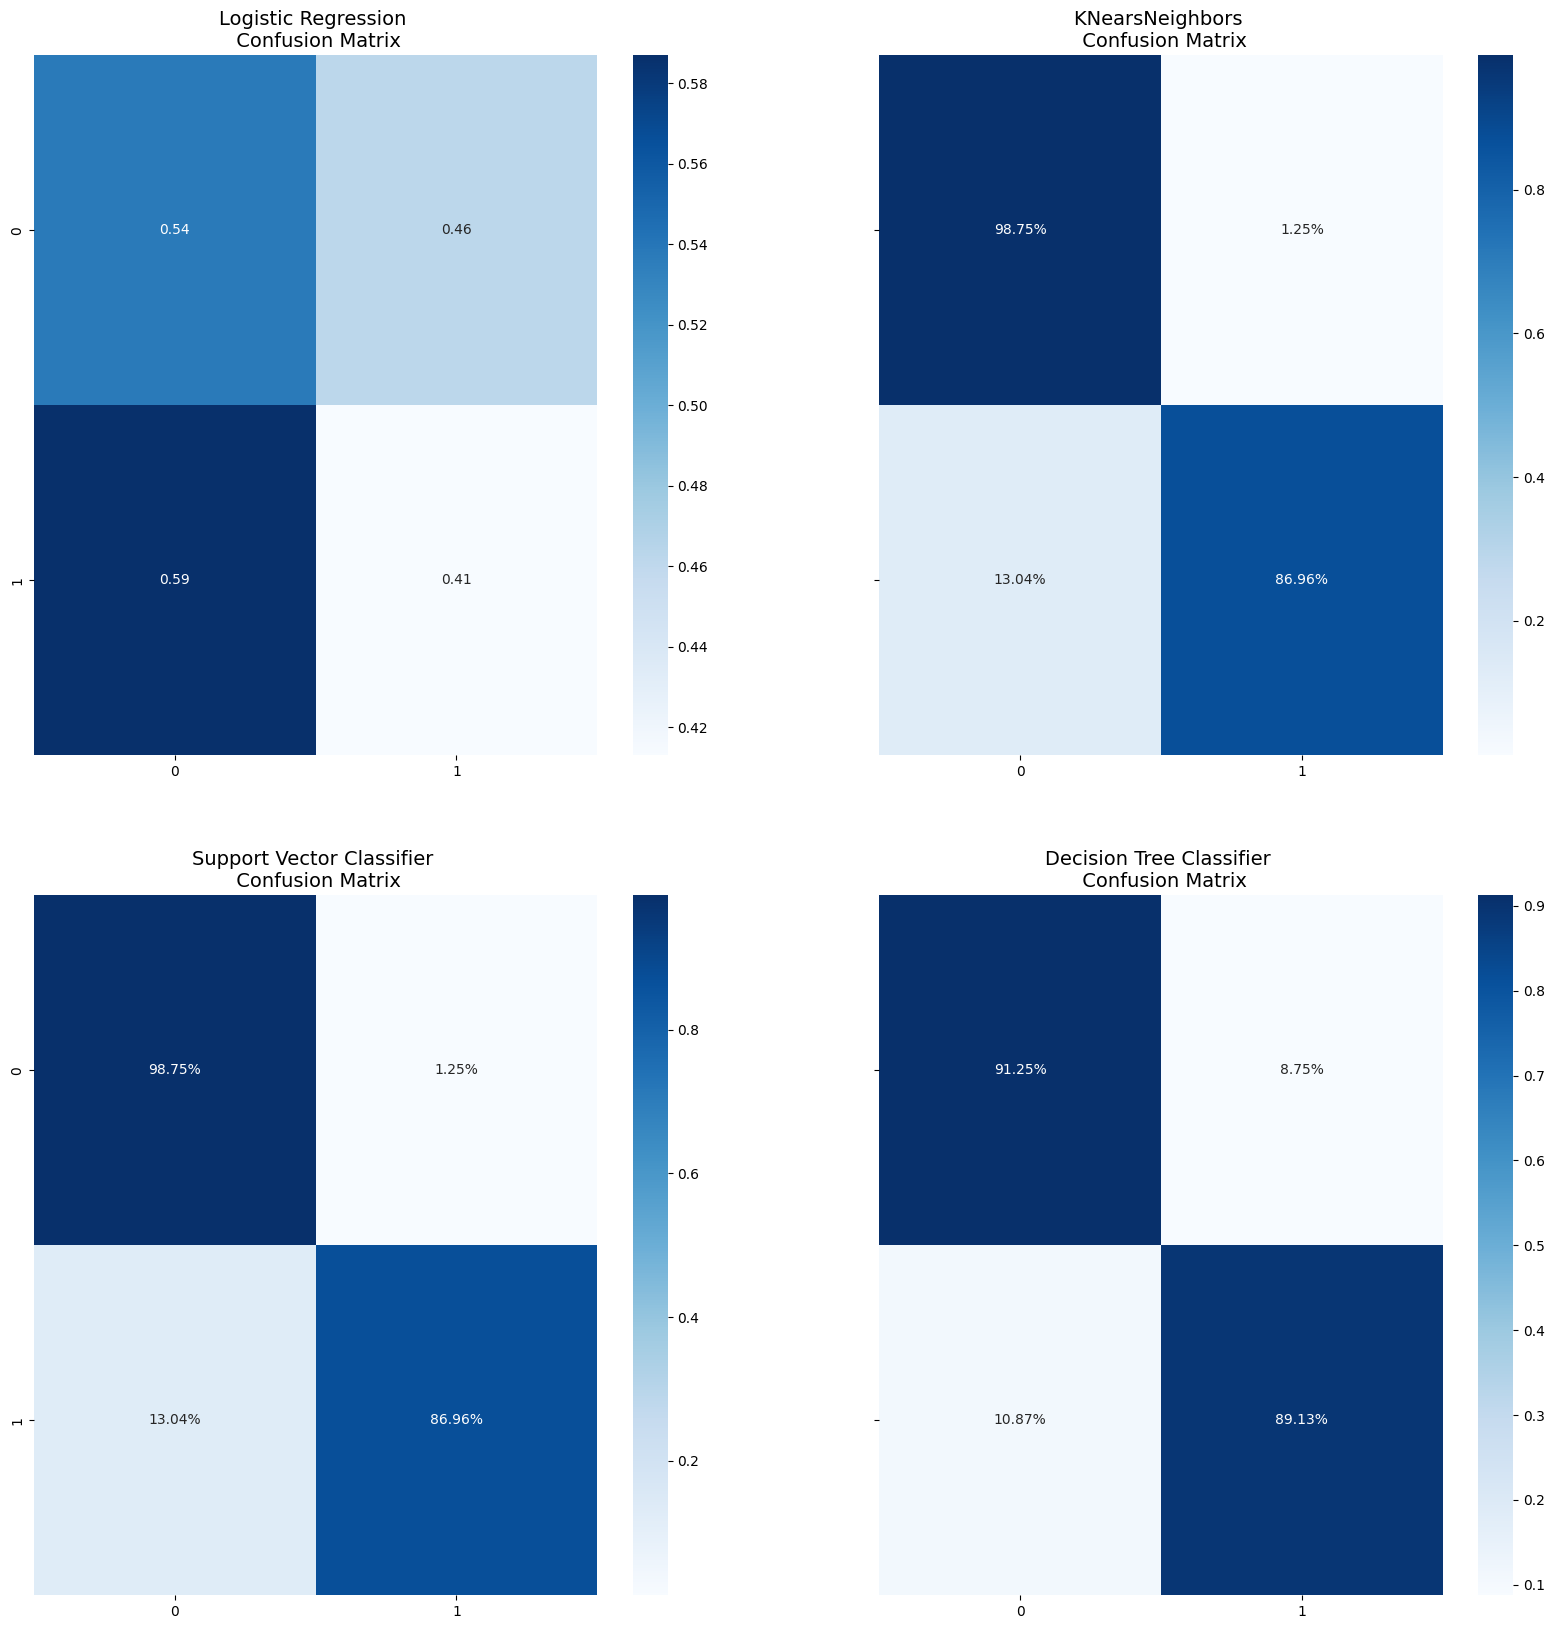

In [ ]:
# Предсказание классов для тестовой выборки с использованием лучшего оценщика логистической регрессии
y_pred_log_reg = best_est.predict(X_test)

# Предсказание классов для тестовой выборки с использованием других моделей
y_pred_knear = knears_neighbors.predict(X_test)  # Предсказание с использованием K-ближайших соседей
y_pred_svc = svc.predict(X_test)  # Предсказание с использованием поддерживающего векторного классификатора (SVC)
y_pred_tree = tree_clf.predict(X_test)  # Предсказание с использованием классификатора на основе дерева решений

# Создание матриц ошибок для каждой модели
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg, normalize='true')  # Матрица ошибок для логистической регрессии, нормализованная
kneighbors_cf = confusion_matrix(y_test, y_pred_knear, normalize='true')  # Матрица ошибок для K-ближайших соседей
svc_cf = confusion_matrix(y_test, y_pred_svc, normalize='true')  # Матрица ошибок для SVC
tree_cf = confusion_matrix(y_test, y_pred_tree, normalize='true')  # Матрица ошибок для дерева решений

# Создание графиков матриц ошибок
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20), sharey=True)  # Устанавливаем размеры графиков и их расположение

# Построение матрицы ошибок для логистической регрессии
sns.heatmap(ax=ax1, data=log_reg_cf, annot=True, fmt='.2f', cmap='Blues')  # Создаем тепловую карту для логистической регрессии
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)  # Устанавливаем заголовок графика

# Построение матрицы ошибок для K-ближайших соседей
sns.heatmap(ax=ax2, data=kneighbors_cf, annot=True, fmt='.2%', cmap='Blues')  # Создаем тепловую карту для K-ближайших соседей
ax2.set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)  # Устанавливаем заголовок графика

# Построение матрицы ошибок для SVC
sns.heatmap(ax=ax3, data=svc_cf, annot=True, fmt='.2%', cmap='Blues')  # Создаем тепловую карту для SVC
ax3.set_title("Support Vector Classifier \n Confusion Matrix", fontsize=14)  # Устанавливаем заголовок графика

# Построение матрицы ошибок для дерева решений
sns.heatmap(ax=ax4, data=tree_cf, annot=True, fmt='.2%', cmap='Blues')  # Создаем тепловую карту для дерева решений
ax4.set_title("Decision Tree Classifier \n Confusion Matrix", fontsize=14)  # Устанавливаем заголовок графика

plt.show()  # Отображаем графики



Давайте вспомним основные метрики качества классификации на примере нашей задачи:

* **Confusion matrix** : так же известна как матрица ошибок, состоит из 4 частей:

    * true positive (TP) : транзакция была мошеннической и модель предсказала ее как мошенническую
    * true negative (TN) : транзакция была нормальной и модель определила ее как нормальную
    * false positive (FP) : транзакция была нормальная, но модель среагировала на нее как на мошенническую
    * false negative (FN) : транзакция была мошенническая, но модель ее пропустила и посчитала нормальной


* **Метрики** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP) (подходит при дисбалансе)
    * Recall : TP / (TP + FN) (подходит при дисбалансе)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall)) (подходит при дисбалансе)

* **Roc-кривая** : ROC-кривая строится путем отрисовки графика зависимости частоты истинных положительных результатов (TPR) от частоты ложных положительных результатов (FPR) при различных пороговых значениях.

In [ ]:
from sklearn.metrics import classification_report



print('Logistic Regression:')
#
y_pred=  best_est.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))

print('KNears Neighbors:')
#
y_pred=  knears_neighbors.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))

print('Support Vector Classifier:')
#
y_pred=  svc.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))

print('Decision Tree Classifier:')
#
y_pred=  tree_clf.predict(original_Xtest)
print(classification_report(original_ytest, y_pred, target_names=labels))


Logistic Regression:
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56863
       Fraud       0.64      0.80      0.71        98

    accuracy                           1.00     56961
   macro avg       0.82      0.90      0.86     56961
weighted avg       1.00      1.00      1.00     56961

KNears Neighbors:
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56863
       Fraud       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Support Vector Classifier:
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56863
       Fraud       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted

In [ ]:
# Логистическая регрессия с under-sampling
y_pred = log_reg.predict(original_Xtest)
undersample_score = accuracy_score(original_ytest, y_pred)

# Логистическая регрессия с over-sampling
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Метод': ['Random Under-Sampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Метод,Score
0,Random Under-Sampling,0.998402
1,Oversampling (SMOTE),0.998894


Воспользуемся другими методами и сравним с предыдущими. Используем только модель логистической регрессии, т.к. она показала лучшие результаты

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:

# Про масштабирование мы с вами уже в курсе. Опять используем RobustScaler
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,
                                                    stratify = y)

X_train['scaled_amount'] = rob_scaler.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_test['scaled_amount'] = rob_scaler.fit_transform(X_test['Amount'].values.reshape(-1,1))

X_train['scaled_time'] = rob_scaler.fit_transform(X_train['Time'].values.reshape(-1,1))
X_test['scaled_time'] = rob_scaler.fit_transform(X_test['Time'].values.reshape(-1,1))


# удаляем из трейн и тест датасетов  столбцы Time и Amount,
# так как у нас уже есть их отмасштабированные версии
X_train.drop(['Time','Amount'], axis=1, inplace=True)
X_test.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
Counter(y_test)

Counter({0: 56864, 1: 98})

**Применяем метод ADASYN over_sampling**

In [ ]:
#Применяем метод ADASYN over_sampling
'''
ADASYN работает аналогично SMOTE, но с добавлением адаптивности. Он уделяет больше внимания классам, которые более
затруднительны для классификации, генерируя больше синтетических примеров для таких классов.
'''

from imblearn.over_sampling import ADASYN

# Создание экземпляра ADASYN
adasyn = ADASYN()

# Применение ADASYN к данным
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 227451, 1: 227464})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 2) * 100, "% accuracy score")


Модель LogisticRegression получила на обучающей выборке 89.0 % accuracy score


In [ ]:
results = {
    "ADASYN (LogisticRegression)":  f"{round(training_score.mean(), 4) * 100}%"
}

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.92      0.96     56864
       Fraud       0.02      0.92      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.92      0.50     56962
weighted avg       1.00      0.92      0.95     56962



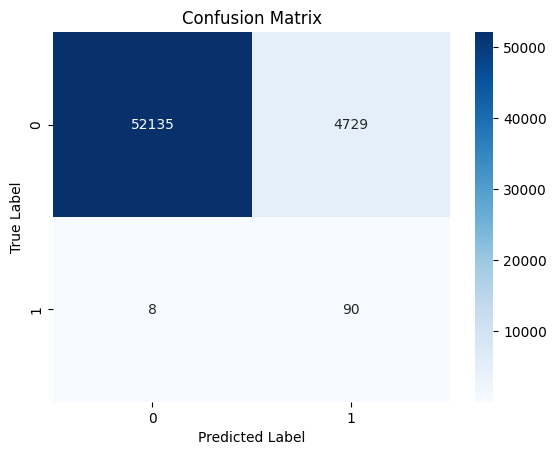

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод RandomOverSampler over_sampling**

In [ ]:
#Применяем метод RandomOverSampler over_sampling
from imblearn.over_sampling import RandomOverSampler

'''
Этот метод случайным образом выбирает примеры из класса-меньшинства и дублирует их, пока не достигнется баланс.
'''

# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [ ]:
Counter(y_resampled)

Counter({0: 227451, 1: 227451})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 2) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 95.0 % accuracy score


In [ ]:
results["RandomOverSampler (LogisticRegression)"] = f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



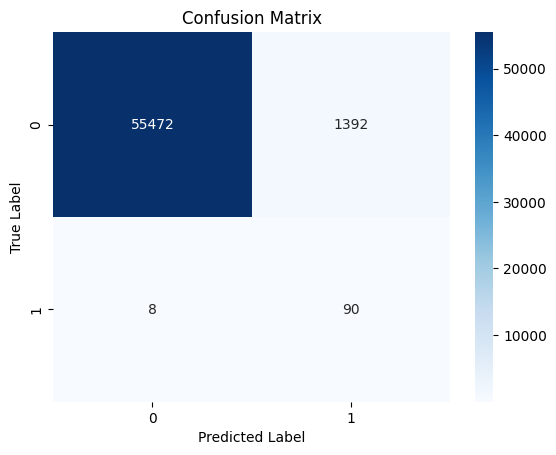

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод RandomUnderSampler under_sampling**

In [ ]:
#Применяем метод RandomUnderSampler under_sampling
from imblearn.under_sampling import RandomUnderSampler
'''
Метод случайным образом отбирает и удаляет экземпляры из доминирующего класса до тех пор, пока количество экземпляров не станет равным количеству экземпляров в меньшем классе
'''
# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 394, 1: 394})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 93.53 % accuracy score


In [ ]:
results["RandomUnderSampler (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.98      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



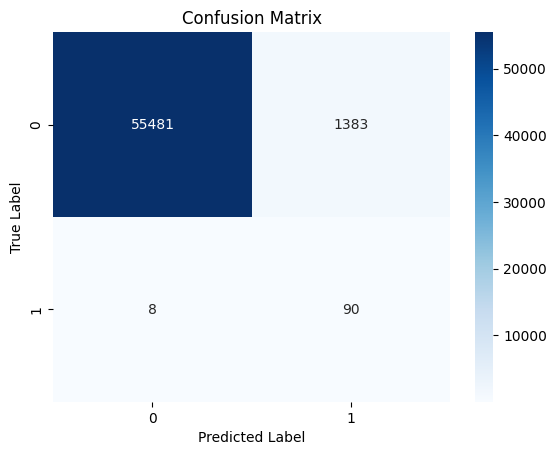

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод NearMiss under_sampling**

In [ ]:
#применяем метод NearMiss under_sampling
from imblearn.under_sampling import NearMiss
'''
Метод находит экземпляры меньшего класса и выбираются экземпляры из большего класса, которые ближе всего к экземплярам меньшего класса
'''

# Инициализация NearMiss
nm = NearMiss(version=1)

# Применение метода
X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 394, 1: 394})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 94.04 % accuracy score


In [ ]:
results["NearMiss (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.81      0.89     56864
       Fraud       0.01      0.92      0.02        98

    accuracy                           0.81     56962
   macro avg       0.50      0.86      0.45     56962
weighted avg       1.00      0.81      0.89     56962



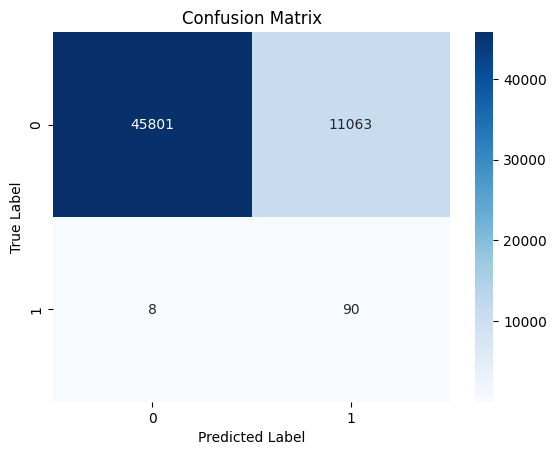

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод ClusterCentroids under_sampling**

In [ ]:
#Применяем метод ClusterCentroids under_sampling
from imblearn.under_sampling import ClusterCentroids
'''
 Метод сначала применяет алгоритм кластеризации (например, K-средних) к экземплярам большего класса.
 После кластеризации из каждого кластера выбирается центроид (среднее значение всех экземпляров в кластере).
 Это создаёт меньшее число «представляющих» экземпляров, которые хорошо описывают больший класс.
 Создается новый сбалансированный набор данных, состоящий из центроидов кластеров большего класса в сочетании с экземплярами меньшего класса.
'''
# Инициализация ClusterCentroids
cc = ClusterCentroids()

# Применение метода
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 394, 1: 394})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 93.78 % accuracy score


In [ ]:
results["ClusterCentroids (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.97      0.98     56864
       Fraud       0.05      0.89      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



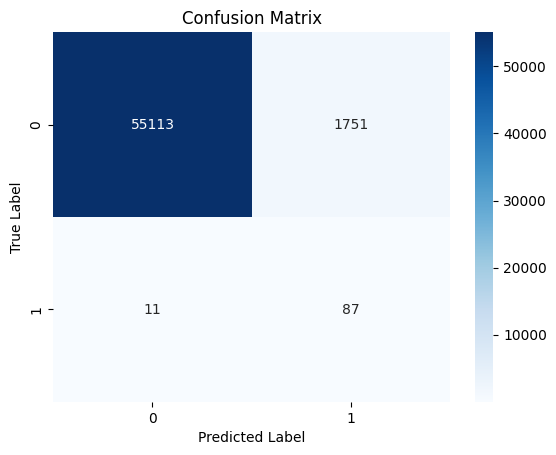

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Применим метод SMOTE Over-Sampling

In [ ]:
from imblearn.over_sampling import SMOTE
'''
Для каждого экземпляра меньшинственного класса SMOTE находит несколько ближайших соседей. Обычно используется метод K-ближайших соседей (KNN).
Для каждой точки из меньшинственного класса SMOTE случайным образом выбирает один из её ближайших соседей.
'''
# Инициализация SMOTE
smote = SMOTE(random_state=42)

# Применение метода
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 227451, 1: 227451})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

In [ ]:
# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 95.35 % accuracy score


In [ ]:
results["Smote (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



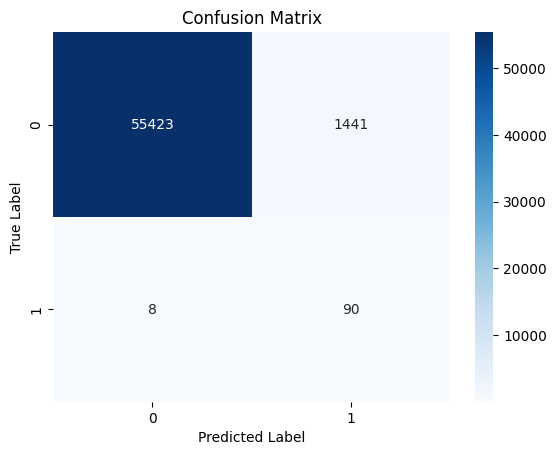

In [ ]:

sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод Borderline-SMOTE over_sampling**

In [ ]:
#Применяем метод Borderline-SMOTE
'''
Этот метод улучшает SMOTE, генерируя синтетические экземпляры только для объектов, находящихся на границе между классами.
'''
from imblearn.over_sampling import BorderlineSMOTE

# Инициализация BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state=42)

# Применение метода
X_resampled, y_resampled = bsmote.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 227451, 1: 227451})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 98.77 % accuracy score


In [ ]:
results["Borderline-SMOTE (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.99      0.99     56864
       Fraud       0.10      0.87      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962



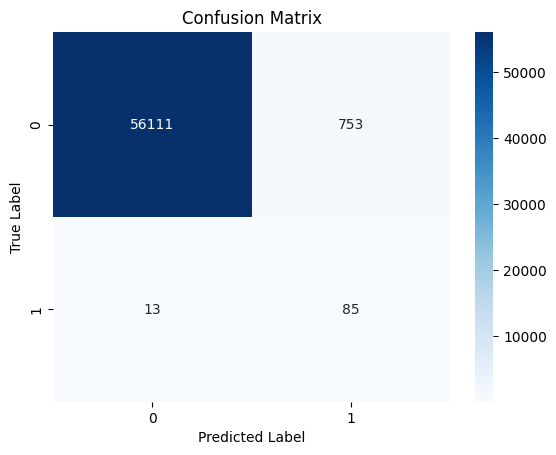

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Применяем метод SVMSmote over_sampling**

In [ ]:
#Применяем метод SVMSmote
'''
SVMSmote использует метод опорных векторов для синтеза новых экземпляров.
Опорный вектора - те точки данных, которые находятся ближе всего к разделяющей гиперплоскости,
которая наилучшим образом разделяет классы объектов в многомерном пространстве
'''
from imblearn.over_sampling import SVMSMOTE

# Инициализация SVMSMOTE
svm_smote = SVMSMOTE(random_state=42)

# Применение метода
X_resampled, y_resampled = svm_smote.fit_resample(X_train, y_train)

In [ ]:
Counter(y_resampled)

Counter({0: 227451, 1: 227451})

In [ ]:
log_reg.fit(X_resampled, y_resampled)
# Выполняем кросс-валидацию, деля обучающий набор на 5 частей (cv=5)
training_score = cross_val_score(log_reg, X_resampled, y_resampled, cv=5)

# Выводим название модели и среднюю точность в процентах с округлением до двух знаков после запятой
print("Модель LogisticRegression получила на обучающей выборке",round(training_score.mean(), 4) * 100, "% accuracy score")

Модель LogisticRegression получила на обучающей выборке 98.85000000000001 % accuracy score


In [ ]:
results["SVMSmote (LogisticRegression)"] =  f"{round(training_score.mean(), 4) * 100}%"

In [ ]:
prediction = log_reg.predict(X_test)
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.99      1.00     56864
       Fraud       0.14      0.90      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962



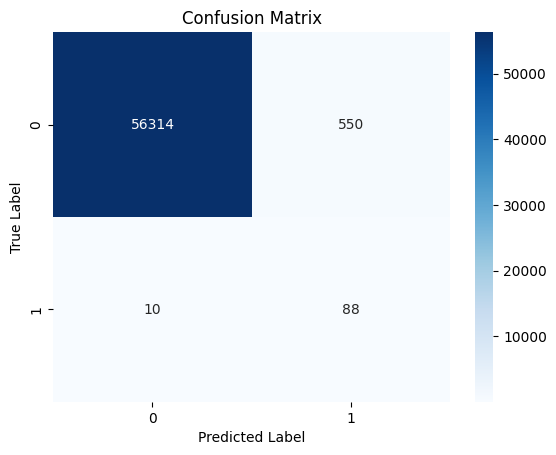

In [ ]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for key, value in results.items():
    print(f"{key}: {value}")

ADASYN (LogisticRegression): 89.25999999999999%
RandomOverSampler (LogisticRegression): 95.05%
RandomUnderSampler (LogisticRegression): 93.53%
NearMiss (LogisticRegression): 94.04%
ClusterCentroids (LogisticRegression): 93.78%
Borderline-SMOTE (LogisticRegression): 98.77%
SVMSmote (LogisticRegression): 98.85000000000001%
Smote (LogisticRegression): 95.35%


Лучшие результаты показал метод SVMSmote
